In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers

In [47]:
class CNN_AE:
  def __init__(self, batch_shape, channels, rows, cols, latent_dim):
    self.encoder = None
    self.decoder = None
    self.autoencoder = None
    self.history = []
    self.batch_shape  = batch_shape
    self.channels = channels
    self.rows = rows
    self.cols = cols

  def build(self):
    input_shape = (self.rows, self.cols, self.channels)
    inputs = tf.keras.Input(input_shape)
    kernel_size = 9
    filter = 4

    self.encoder = tf.keras.Sequential([
        layers.Reshape(input_shape, input_shape=input_shape),
        layers.Conv2D(filters=128, kernel_size=(5, 5), padding='same',
                      activation='selu'),
        layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same',
                      activation='selu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=32, kernel_size=(9, 9), padding='same',
                      activation='selu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=16, kernel_size=(9, 9), padding='same',
                      activation='selu'),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(filters=16, kernel_size=(9, 9), padding='same',
                               activation='selu'),
        layers.Conv2DTranspose(filters=32, kernel_size=(9, 9), padding='same',
                               activation='selu'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(filters=64, kernel_size=(7, 7), padding='same',
                               activation='selu'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), padding='same',
                               activation='selu'),

        layers.Conv2DTranspose(filters=self.channels, kernel_size=3, padding='same',
                               activation='sigmoid'),
        layers.Reshape((self.rows, self.cols, self.channels))
    ])

    self.autoencoder = tf.keras.Sequential([self.encoder, self.decoder])
    return self.autoencoder

  def train(self, images_train, images_test, epochs=10):
    self.autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                             loss=tf.keras.losses.MeanSquaredError())

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best', monitor='val_loss', save_best_only=True, verbose=0, mode='min')

    history = self.autoencoder.fit(images_train, images_train, epochs=epochs,
                                  shuffle=True,
                                  batch_size=self.batch_shape,
                                  validation_data=(images_test, images_test),
                                  callbacks=[early_stopping, checkpoint])
    self.history.append(history)
    self.autoencoder = tf.keras.models.load_model('best')
    return self.history

  def print_history(self, index=-1, figsize=(10, 8)):
    history = self.history[index].history

    plt.figure(figsize=figsize)
    plt.plot(history['loss'], label="Train loss")
    plt.plot(history['val_loss'], label="Validation loss")
    plt.legend()
    plt.title("History Loss")

  def predict(self, x):
    return self.autoencoder.predict(x)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
nb_images = x_train.shape[0]
rows = x_train.shape[1]
cols = x_train.shape[2]
channels = 3


x_train = x_train.reshape(nb_images, rows, cols, channels)
x_test = x_test.reshape(x_test.shape[0], rows, cols, channels)

x_train.shape

(50000, 32, 32, 3)

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

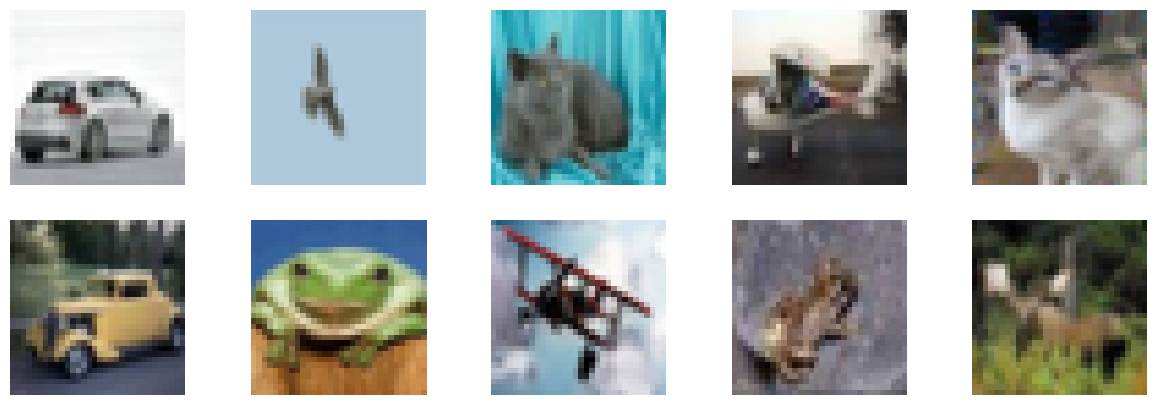

In [9]:
plt.figure(figsize=(15, 5))


for img, i in zip(tf.random.uniform((1, 10),
                  maxval=nb_images, dtype='int32',
                  seed=tf.random.set_seed(0))[0],
                  range(1, 11)):
  plt.subplot(2, 5, i)
  plt.imshow(x_train[img], cmap='gray')
  plt.axis('off')

plt.subplots_adjust(wspace=0.2)


In [48]:
model = CNN_AE(32, channels, rows, cols, 64)
model.build()

In [50]:
model.train(x_train, x_test, 10)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 0.0239

1563/1563 [==============================] - 45s 27ms/step - loss: 0.0239 - val_loss: 0.0095
Epoch 2/10
1561/1563 [============================>.] - ETA: 0s - loss: 0.0085

1563/1563 [==============================] - 43s 27ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 3/10
1562/1563 [============================>.] - ETA: 0s - loss: 0.0077

1563/1563 [==============================] - 42s 27ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 4/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 5/10
1562/1563 [============================>.] - ETA: 0s - loss: 0.0050

1563/1563 [==============================] - 42s 27ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 6/10
1561/1563 [============================>.] - ETA: 0s - loss: 0.0045

1563/1563 [==============================] - 42s 27ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 7/10
1563/1563 [==============================] - ETA: 0s - loss: 0.0040

1563/1563 [==============================] - 42s 27ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 8/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 9/10
1563/1563 [==============================] - ETA: 0s - loss: 0.0037

1563/1563 [==============================] - 41s 26ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 10/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0035 - val_loss: 0.0031


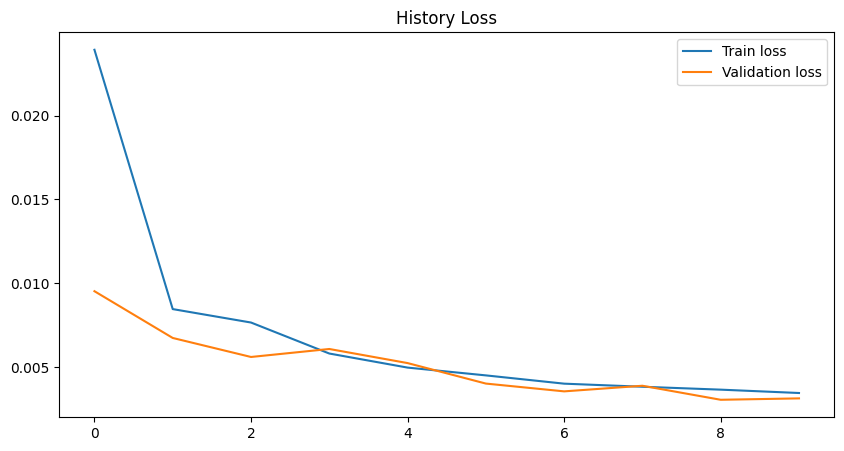

In [51]:
model.print_history(figsize=(10, 5))

In [52]:
decoded_images = model.predict(x_test)

313/313 [==============================] - 2s 7ms/step


Text(0.5, 1.0, 'decoded')

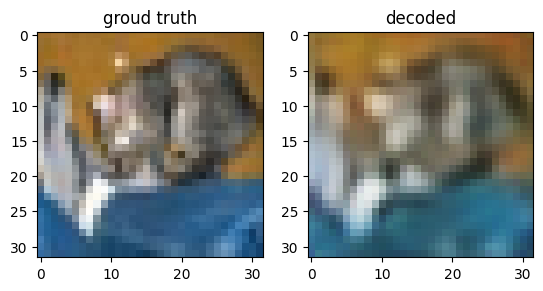

In [54]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_test[0], cmap='gray')
plt.title("groud truth")

plt.subplot(1, 2, 2)
plt.imshow(decoded_images[0], cmap='gray')
plt.title("decoded")


In [55]:
model.autoencoder.evaluate(decoded_images, x_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0050


0.005027680657804012